In [23]:
import pandas as pd
from fastai import *
from fastai.text import * 

In [46]:
DATA_PATH = './data'

# DATA PREPARATION

In [25]:
def prepare_csv(source, target):
    df = pd.read_csv(source, sep= '%%%%', header=None)
    df[['label', 'question']] = df.iloc[:,0].str.split(":", n = 1, expand = True) 
    df[['label_detail', 'question']] = df.question.str.split(" ", n = 1, expand = True) 
    df = df.drop(df.columns[0], axis=1)
    df.to_csv(target, index=False)

In [26]:
prepare_csv(DATA_PATH  + '/TREC_10.label', DATA_PATH  + '/TREC_10.csv')
prepare_csv(DATA_PATH  + '/train_5500.label', DATA_PATH  + '/train_5500.csv' )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [27]:
df_valid = pd.read_csv(DATA_PATH  + '/TREC_10.csv')
df_train = pd.read_csv(DATA_PATH  + '/train_5500.csv')
df_valid['is_valid'] = 1
df_train['is_valid'] = 0
df_all = pd.concat([df_valid, df_train], ignore_index=True)

# LANGUAGE MODEL

In [28]:
# Creating databunch with all data for language model
databunch_lm = (
        TextList.from_df(df=df_all, path=DATA_PATH, cols=['question'])
            .split_by_rand_pct()
            .label_for_lm()
            .databunch())

databunch_lm.save('databunch_lm.pkl')
databunch_lm = load_data(DATA_PATH, fname='databunch_lm.pkl')

In [29]:
# Creating learner with pretrained model
language_model_learner = language_model_learner(databunch_lm, TransformerXL, drop_mult=0.05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04


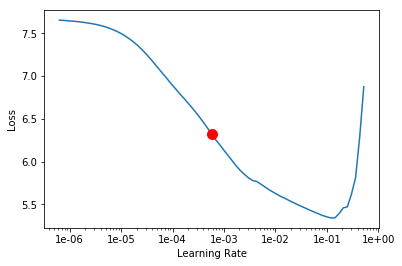

In [8]:
# Finding the best learning rate 

language_model_learner.lr_find()
language_model_learner.recorder.plot(suggestion=True)

In [21]:
#language_model_learner.summary()

In [30]:
# Training only last layer
language_model_learner.unfreeze()
language_model_learner.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.760022,4.814991,0.288783,07:18
1,4.927503,3.718053,0.355022,07:16
2,4.356023,3.326693,0.374609,07:16
3,3.972460,3.073159,0.437891,07:16
4,3.677504,2.953013,0.451562,07:15
5,3.436961,2.838651,0.468973,07:14
6,3.234573,2.759929,0.482813,07:14
7,3.063272,2.715398,0.487500,07:14
8,2.911452,2.683595,0.490513,07:14
9,2.772099,2.665521,0.495871,07:15


In [31]:
# Saving encoder
language_model_learner.save_encoder('encoder_transformer_xl')

# CLASSIFIER

In [32]:
# Creating databunch with all data for classifier using previous vocab
databunch_classifier = (
        TextList.from_df(df=df_all, path=DATA_PATH, cols=['question'], vocab=databunch_lm.train_ds.vocab)
            .split_from_df(col='is_valid')
            .label_from_df(cols='label')
            .databunch())

databunch_classifier.save('databunch_classifier.pkl')
databunch_classifier = load_data(DATA_PATH, fname='databunch_classifier.pkl', bs=16)

In [33]:
# Creating text classifier learner
classifier_learner = text_classifier_learner(databunch_classifier, TransformerXL, drop_mult=0.05)
classifier_learner.load_encoder('encoder_transformer_xl')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/fastai/text/learner.py:294: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


In [34]:
# Example of a batch
databunch_classifier.show_batch()

text,target
"xxbos xxmaj who was named xxmaj xxunk of the xxmaj ocean xxmaj seas and xxmaj xxunk and xxmaj governor xxmaj general of all the islands he xxunk discover , and also xxunk xxunk ? ? of all xxunk of his xxunk",HUM
xxbos xxmaj what xxmaj french xxunk xxunk : ` ` xxmaj the jean is the xxunk ! xxmaj it is a dictator ! xxmaj it is xxunk xxunk . xxmaj the jean must be xxunk ! '',HUM
"xxbos xxmaj in xxmaj xxunk 's ` ` xxmaj two xxmaj years xxmaj before the xxmaj xxunk , '' what xxunk lived in an xxunk oven on the beach at xxmaj san xxmaj diego",HUM
xxbos xxmaj who xxunk ` ` i know '' to xxmaj xxunk xxmaj xxunk 's xxunk ` ` i love you '' in xxmaj the xxmaj empire xxmaj xxunk xxmaj back,HUM
xxbos xxmaj what xxup tv xxunk show left the air in 1975 to the xxunk of xxmaj xxunk xxmaj xxunk 's xxmaj we 'll xxmaj xxunk xxmaj again,ENTY


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02


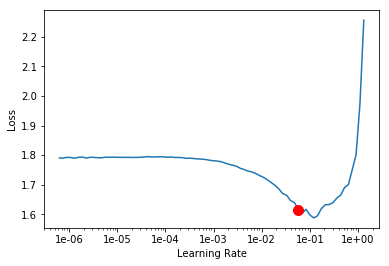

In [35]:
# Finding learning rate

classifier_learner.lr_find()
classifier_learner.recorder.plot(suggestion=True)

In [36]:
# Training only last layer
classifier_learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.980073,0.835226,0.752000,02:42


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


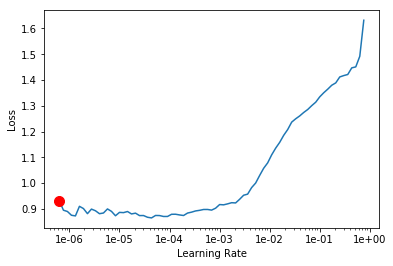

In [37]:
# Finding the best learning rate when unfreezed

classifier_learner.unfreeze()
classifier_learner.lr_find()
classifier_learner.recorder.plot(suggestion=True)

In [38]:
classifier_learner.unfreeze()
classifier_learner.fit_one_cycle(15, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.920830,0.748438,0.798000,07:16
1,0.810489,0.708375,0.806000,07:29
2,0.726657,0.523530,0.846000,07:28
3,0.594130,0.433752,0.880000,07:25
4,0.445713,0.373838,0.880000,07:22
5,0.348786,0.411974,0.888000,07:36
6,0.231641,0.375729,0.888000,07:25
7,0.181997,0.350016,0.884000,07:17
8,0.144613,0.323190,0.906000,07:22
9,0.116994,0.308904,0.914000,07:25


In [39]:
classifier_learner.export('classifier_transformer_xl.pkl')

In [50]:
classifier_learner = load_learner(DATA_PATH,'classifier_transformer_xl.pkl')

In [51]:
classifier_learner.predict("How many players are in a football field?")


(Category NUM,
 tensor(5),
 tensor([5.1380e-03, 3.1437e-04, 5.3060e-05, 4.9104e-03, 3.5748e-04, 9.8923e-01]))